In [5]:
import datetime
tick = datetime.datetime.now()

# Load libraries and helper functions

In [6]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Lambda, GRU, SimpleRNN, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from utils import *
tf.keras.backend.set_floatx('float64')

2.5.0


Install keras-tuner if you try to run this on colab.

In [7]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False
if IS_COLAB:
    !pip install keras-tuner

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

No GPU was detected. CNNs can be very slow without a GPU.


In [8]:
import kerastuner as kt

# Load single series

The data folder contains sales data (value and volume) for different regions of over the counter treatments for common cold and flu.

The client wants:
- predictions 8 weeks ahead
- a mape below 10%

In [19]:
import os
datadir = './data/'
files = os.listdir(datadir)
files = [os.path.join(datadir, file) for file in files]
files

['./data/02_value.csv',
 './data/04_volume.csv',
 './data/01_volume.csv',
 './data/.DS_Store',
 './data/04_value.csv',
 './data/03_value.csv',
 './data/06_volume.csv',
 './data/03_volume.csv',
 './data/05_value.csv',
 './data/00_volume.csv',
 './data/00_value.csv',
 './data/06_value.csv',
 './data/05_volume.csv',
 './data/01_value.csv',
 './data/02_volume.csv',
 './data/07_value.csv',
 './data/07_volume.csv']

Let's load one series

In [17]:
file = [x for x in files if '00_volume' in x][0]
series = read_single_file(file)
series.info()

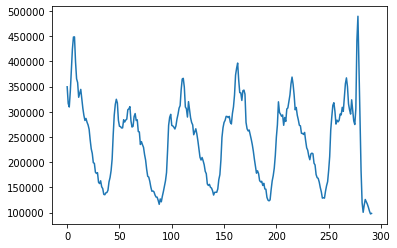

In [20]:
plt.plot(series)

Let's cut off the corona anomalies at the end.

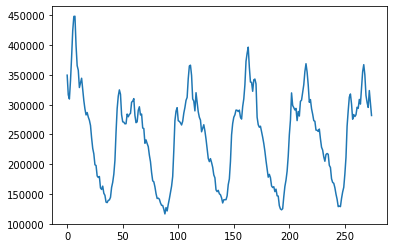

In [21]:
series = series[:275]
plt.plot(series)

## train-test split, normalize

We will have to make a train-test split.

Remember, with timeseries, you should always do it like this: the past is the train set, the future is the test set.

Using a random approach will lead to data-leaking and thus to overperformance! Make sure you understand why this is the case. It might seem like a detail, but it is not!

max: 0    448540.60504
dtype: float64


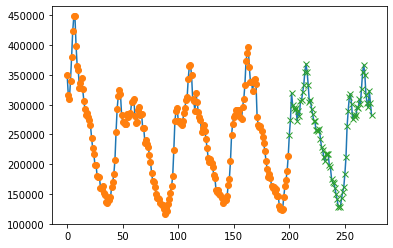

In [22]:
split_time = 200
x_train = series[:split_time]
x_valid = series[split_time:]
plt.plot(series)
plt.plot(x_train, 'o')
plt.plot(x_valid, 'x')

norm = x_train.max()
print('max:', norm)
x_train = x_train / norm
x_valid = x_valid / norm

In [23]:
# shape: (timesteps , features)
x_train.shape, x_valid.shape

((200, 1), (75, 1))

Set the correct horizon, depending on the clients requirements.

In [24]:
# make windowed dataset
window_size = 32
batch_size = 32
shuffle_buffer_size = 32
horizon = # your code here

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size, horizon)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size, horizon)

In [25]:
for x, y in train_set:
    print(x.shape)
    print(y.shape)
    seq_size = x.shape[1]
    break

for x, y in valid_set:
    print(x.shape)
    print(y.shape)
    break

(32, 32, 1)
(32, 8, 1)
(32, 32, 1)
(32, 8, 1)


In [26]:
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

# Look for a model

Let's explore a few models. A `mape` accuracy of around 85% is reasonable for this dataset.

In [27]:
for x, y in train_set:
    print(x.shape)
    print(y.shape)
    break

(32, 32, 1)
(32, 8, 1)


In [28]:
result = {}

Start with a baseline with one Dense(horizon) layer. horizon refers to the amount of outputs you need for the horizon of the prediction. Pay attention to the correct input shape! What is the input shape of your data? What is the input shape your Dense layer expects?

In [ ]:
%%time
# Baseline model, just a linear model

# your model here

model.compile(loss="mse", optimizer=Adam(learning_rate=1e-2), metrics=['mape'])
result['base'] = model.fit(train_set,epochs=100, validation_data=valid_set, callbacks=[early_stop], verbose=0)

In [ ]:
model.summary()

In [ ]:
plot_results(result, ymax = 0.1)

In [ ]:
model.evaluate(valid_set)

Now, create a simple RNN with just one unit, and a Dense layer. Test this with a for loop for [1e-2, 1e-3, 1e-4] learning rates.

Try to predict what will happen. What do you expect for the different rates in terms of:

- accuracy
- speed
- stability

In [ ]:
%%time

# your code here

In [ ]:
plot_results(result, ymax = 0.1)

In [ ]:
%%time

# your code here

In [ ]:
plot_results(result, ymax = 0.1)

Interpret the mape. What seems to work better?

Expand the amount of units of your RNN to 16, and test for the same range or learning rates.
Also, test both ADAM and SGD with momentum.

Again, try to formulate a hypothesis first.

What do you expect in terms of accuracy? speed? stability?

And why do you expect that? (cf., try to give a reason instead of just guessing).

In [ ]:
%%time

# your code here

In [ ]:
plot_results(result, ymax = 0.1)

Discuss what you see. 
- What does this all mean?
- What seems to be the impact of the learning rate (both in terms of accuracy and stability)?
- can you explain why the learning rate has this impact?
- What is the impact of the optimizer? Is this impact bigger or smaller than you expected?

Let's clean up some of the experiments we dont need. (note that this would be much easier with tensorboard)


In [ ]:
allkeys = list(result.keys())
allkeys

In [ ]:
for key in allkeys:
    if key not in ['base','Deep_RNN_SGD_lr0.01']:
        print(key)
        del result[key]

Then, try a SimpleRNN with SGD and `learning_rate=1e-3` and `momentum=0.9` and test three layers of SimpleRNN. Make a forloop to test 32, 64 and 96 units.

Again, try to make predictions about:
- speed
- accuracy
- stability

In [ ]:
# your code

In [ ]:
plot_results(result, ymax=0.05)

Now, switch to GRU to see if that improves the simple RNN. Use a forloop to test three layer GRUs with 32, 64 and 96 units.

In [ ]:
# your code here

In [ ]:
plot_results(result, ymax = 0.02, figsize=(15,8), moving=5)

Now let's fixate the amount of units, based on your experiments so far, and add Conv1D filters to your best model.

In [ ]:
%%time
# your code here

You probably improved with Conv1D layer, again.

Problem is, it is hard to figure out what the best architecture is by freezing parameters and then adding new ones. It could be the case, that we have a complete new situation with the addition of the Conv1D layer, and thus that freezing the parameter for a layer without Conv1D is suboptimal. We are getting kind of lost in the multitude of options and possible interactions.

Hyperparametersettings and layers will interact, sometimes in unexpected ways. Maybe we would improve again if we **reduce** the amount of layers in combination with a conv1d layer.

The point here is, that while it is very usefull to play around with your model to get a good intuition of how your data reacts to changing learning rates, more units, other layers, etc, a lot of the times we can improve the architecture with a hypermodel.

Playing around often gives a good idea of what the fruitful areas are for your search; e.g should you think of units below 100? Or should you consider ranges up to 500 units? 

 # Hypermodel
The problem here is, that we can't just keep adding options and ranges. It will make our searchspace much to big, and the tuner is never able to try them all out. So, be carefull when adding a lot of features! 
 Another way to handle this is to start with a very broad model, and start to fix certain values if you are more confident that they shouldn't be changed.

Build a hypermodel. add parameters for:
- amounts of filters
- kernelsize
- GRU or LSTM
- amount of additional GRU/LSTM layers (be sure to also try 0 additional layers)

Be aware that our models are getting much slower to train. So increasing the `patience` in your `EarlyStopping` to a value of `20`, instead of `10`, when training your best model. With `10`, you might stop too early in the final model.

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, GRU, MaxPool1D

def build_model(hp):

    # your model here


    return model

In [ ]:
from kerastuner import HyperParameters
hp = HyperParameters()

In [ ]:
%%time
import kerastuner as kt
# cleaning up folders from old runs

tuner = kt.Hyperband(
    build_model,
    hyperparameters = hp,
    tune_new_entries=True,
    objective='val_loss',
    max_epochs=10,
    seed=12,
    hyperband_iterations=3,
    directory='ktuner',
    project_name='ts',
    overwrite=True
)
tuner.search(train_set, validation_data = valid_set)

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_hps.values

In [ ]:
model = tuner.get_best_models()[0]
model.summary()

Fit your best model for 200 epochs.

In [ ]:
%%time
early_stop = EarlyStopping(patience=20, restore_best_weights=True)
logdir = os.path.join("logs", "hyper")
tb = TensorBoard(logdir, histogram_freq=1)
result['hyper'] = model.fit(train_set, epochs=200, validation_data=valid_set, callbacks=[early_stop, tb], verbose = 0)

In [ ]:
model.evaluate(valid_set)

You should be able to get below 10%.

Reflect on the process: is this much different from what you started out with, initially?
Does the hypertuning surprise you? If so, why?

Additionally, you could test this out on other regions. 

Let's see how that looks with a horizon of 8 in the actual prediction:

In [ ]:
h = 8
#generate_prediction(model, pd.concat([x_train, x_valid]), window = seq_size, horizon = horizon);
generate_prediction(model, x_valid, window = seq_size, horizon = h);

In [ ]:
h = 4
generate_prediction(model, x_valid, window = seq_size, horizon = h);

In [ ]:
tock = datetime.datetime.now()
tock - tick